In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.5 MB/s eta 0:00:00


In [ ]:
# Imports
import gymnasium
from gymnasium import spaces
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Stock Trading Environment

In [ ]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gymnasium.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path
        self.stock_data = pd.read_csv(self.file_path)
        self.train = train

        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

        self.observation_space = spaces.Discrete(4)
        self.action_space = spaces.Discrete(3)

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.

                 info: - info: - A dictionary that can be used to provide additional implementation information."""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector that will be passed to the agent.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector.
            observation = [price_increase, stock_held]

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        info = None

        return observation, info

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - Integer in the range 0 to 2 inclusive.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.
                 reward: - Integer/Float value that's used to measure the performance of the agent.
                 terminated: - Boolean describing whether the episode has terminated.
                 truncated: - Boolean describing whether a truncation condition outside the scope of the MDP is satisfied.
                 info: - A dictionary that can be used to provide additional implementation information."""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = True
        else:
            stock_held = False

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the maximum timesteps have been reached.
        terminated = True if (self.timestep >= self.max_timesteps) \
            else False
        truncated = False
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# NOTE: You can adjust the parameter 'number_of_days_to_consider'

stock_trading_environment = StockTradingEnvironment('/content/drive/MyDrive/RL_Assignment_1_Part3/NVDA.csv', number_of_days_to_consider=10)

### TO DO: Implement the Q-learning algorithm

In [ ]:
def map_observation_to_state(observation):
    #Map observation to state index
    if observation == [True, False]:
        return 0
    elif observation == [True, True]:
        return 1
    elif observation == [False, False]:
        return 2
    elif observation == [False, True]:
        return 3



In [ ]:
def Q_learning(environment, num_episodes, max_steps_per_episode, alpha, gamma, epsilon, epsilon_decay, min_epsilon):

    num_actions = 3
    num_states = environment.observation_space.n
    q_table = np.zeros((num_states, num_actions))
    rewards_all_episodes = []
    epsilon_values = []

    print("Initial Q-table:")
    print(q_table)

    for episode in range(num_episodes):

        T_state = environment.reset()
        #state = state_2d[0] * environment_width + state_2d[1]
        state = T_state[0] #T_state : State is in tuple,so we're extracting the state from the tuple

        total_rewards = 0

        for step in range(max_steps_per_episode):
            if np.random.uniform(0,1) < epsilon:
                action = np.random.randint(0, num_actions)  #Exploration
            else:
                action = np.argmax(q_table[state, :])  #Exploitation


            #Convert the new 2-D state to a 1-D index
            #new_state = new_state_2d[0] * environment_width + new_state_2d[1]
            #print(f"Episode: {episode}, Step: {step}, State: {state}, Action: {action}")

            new_T_state, reward, done, truncated, info = environment.step(action)

            if isinstance(new_T_state, int):
                new_T_state = (new_T_state,)

            new_state = new_T_state[0] #Extracting the new state from the tuple

            #Updating Q-Table
            q_table[state, action] = q_table[state, action] * (1 - alpha) + \
                             alpha * (reward + gamma * np.max(q_table[new_state, :]))


            total_rewards += reward
            state = new_state

            if done:
                break

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards_all_episodes.append(total_rewards)
        epsilon_values.append(epsilon)

        print(f"Episode: {episode}, Reward: {total_rewards}, Epsilon: {epsilon}")

    return q_table, rewards_all_episodes, epsilon_values

In [ ]:
num_episodes = 1000
max_steps_per_episode = 100
alpha = 0.15  #Learning rate
gamma = 0.93  #Discount factor
epsilon = 1.0
epsilon_decay = 0.99
min_epsilon = 0.01

environment = StockTradingEnvironment(file_path = '/content/drive/MyDrive/RL_Assignment_1_Part3/NVDA.csv')

q_table, rewards_all_episodes, epsilon_values = Q_learning(environment, num_episodes, max_steps_per_episode, alpha, gamma, epsilon, epsilon_decay, min_epsilon)


Initial Q-table:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Episode: 0, Reward: -246.78947902837734, Epsilon: 0.99
Episode: 1, Reward: -366.72914509466193, Epsilon: 0.9801
Episode: 2, Reward: -354.3906239000181, Epsilon: 0.9702989999999999
Episode: 3, Reward: -364.76828422916236, Epsilon: 0.96059601
Episode: 4, Reward: -159.3476247356279, Epsilon: 0.9509900498999999
Episode: 5, Reward: -355.85528054049996, Epsilon: 0.9414801494009999
Episode: 6, Reward: -334.9593984867177, Epsilon: 0.9320653479069899
Episode: 7, Reward: -270.43939772882806, Epsilon: 0.92274469442792
Episode: 8, Reward: -206.6590572151419, Epsilon: 0.9135172474836407
Episode: 9, Reward: -256.8100910785909, Epsilon: 0.9043820750088043
Episode: 10, Reward: -204.87997085852402, Epsilon: 0.8953382542587163
Episode: 11, Reward: -296.95923302604865, Epsilon: 0.8863848717161291
Episode: 12, Reward: -326.7575704574098, Epsilon: 0.8775210229989678
Episode: 13, Reward: -126.11643386447834, Epsilon: 0.8687458127689781
Episod

In [ ]:
print("Q-table:")
print(q_table)

Q-table:
[[132.67969107  91.18579413  73.91090292]
 [109.95564754 112.00977575 216.94027468]
 [124.18555811  81.76688839  94.48151767]
 [ 79.82640428 118.3338995   89.12629908]]


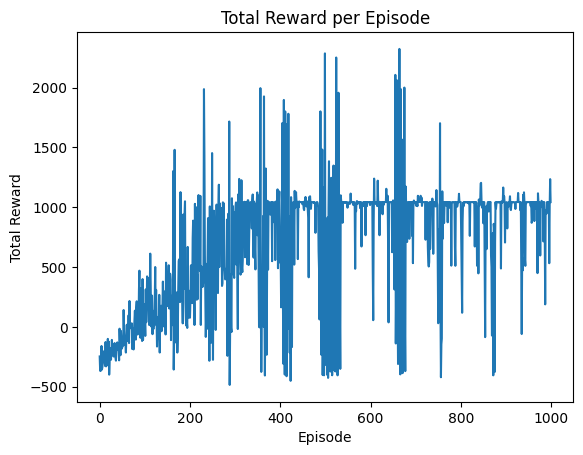

In [ ]:
plt.plot(rewards_all_episodes)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

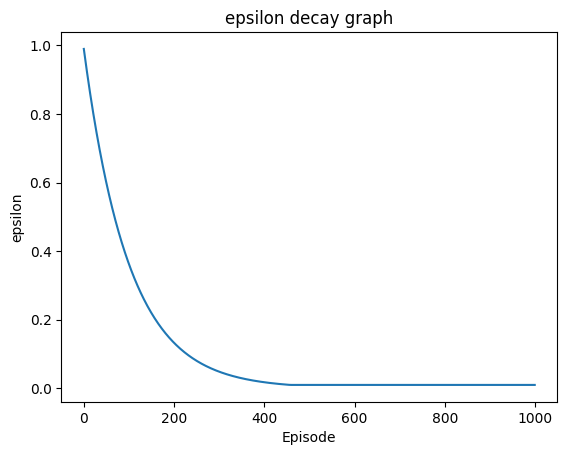

In [ ]:
plt.plot(epsilon_values)
plt.title('epsilon decay graph')
plt.xlabel('Episode')
plt.ylabel('epsilon')
plt.show()

Episode 0: Total Reward = 653.8940718430614
Episode 1: Total Reward = 653.8940718430614
Episode 2: Total Reward = 653.8940718430614
Episode 3: Total Reward = 653.8940718430614
Episode 4: Total Reward = 653.8940718430614
Episode 5: Total Reward = 653.8940718430614
Episode 6: Total Reward = 653.8940718430614
Episode 7: Total Reward = 653.8940718430614
Episode 8: Total Reward = 653.8940718430614
Episode 9: Total Reward = 653.8940718430614


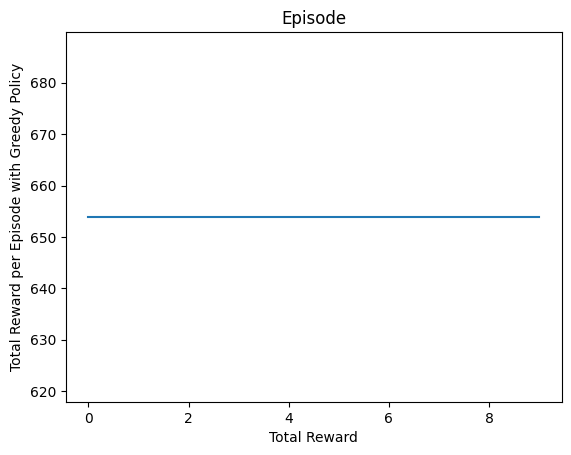

In [ ]:
def trained_model(environment, q_table, episodes):
    environment.train = False
    total_rewards = []

    for episode in range(episodes):
        state_tuple = environment.reset()
        if isinstance(state_tuple, int):
            state = state_tuple  #If the state is already an int, use it directly
        else:
            state = state_tuple[0] #If the state is a tuple, extract the integer state

        done = False
        total_reward = 0

        while not done:
            action = np.argmax(q_table[state, :])
            new_state_tuple, reward, done, truncated, _ = environment.step(action)
            if isinstance(new_state_tuple, int):
                new_state = new_state_tuple
            else:
                new_state = new_state_tuple[0]

            total_reward += reward
            state = new_state

        total_rewards.append(total_reward)
        print(f"Episode {episode}: Total Reward = {total_reward}")

    return total_rewards

num_episodes = 10

total_rewards = trained_model(environment, q_table, num_episodes)

plt.plot(total_rewards)
plt.title('Episode')
plt.ylabel('Total Reward per Episode with Greedy Policy')
plt.xlabel('Total Reward')
plt.show()

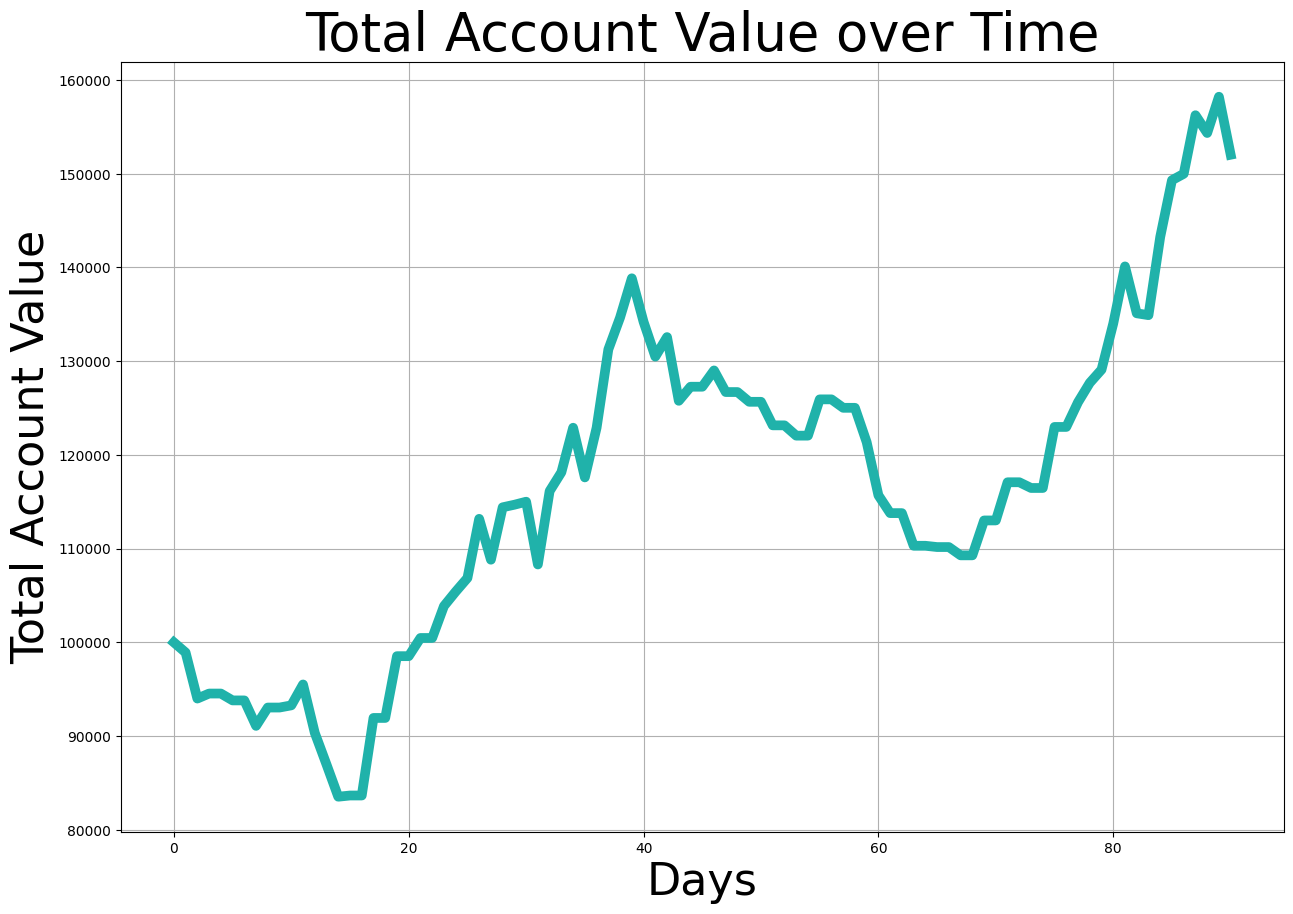

In [ ]:
environment.render()
